In [1]:
# # Importing the required packages

using CirculatorySystemModels
using ModelingToolkit
using OrdinaryDiffEq
using Plots
using DisplayAs

# A simple single-chamber model

![Single chamber, closed-loop, lumped parameter model of the systemic circulation and the left ventricle. The circuit equivalent formulation of the model is depicted, with the pressures of each compartment, as well as most of the mechanical parameters. The model describes three compartments: the left ventricular, arterial and venous compartments. 𝑃𝑡ℎ is the intrathoracic pressure, 𝑃𝑙𝑣 is the left ventricular pressure and 𝐸𝑙𝑣(𝑡) indicates the left ventricular elastance function.](./BjordalsbakkeModelSketch.png)


This follows Bjørdalsbakke et al.

Bjørdalsbakke, N.L., Sturdy, J.T., Hose, D.R., Hellevik, L.R., 2022. Parameter estimation for closed-loop lumped parameter models of the systemic circulation using synthetic data. Mathematical Biosciences 343, 108731. https://doi.org/10.1016/j.mbs.2021.108731


Changes from the published version above:

- Capacitors are replaced by compliances. These are identical to capacitors, but have an additional parameter, the unstrained volume $V_0$, which allows for realistic blood volume modelling.
  Compliances have an inlet and an oulet in line with the flow, rather than the ground connector of the dangling capacitor.
- The aortic resistor is combined with the valve (diode) in the `ResistorDiode` element.

[Jupyter Notebook](./BjordalsbakkeModel.ipynb)

## Define the parameters

All the parameters are taken from table 1 of [Bjørdalsbakke2022].

Cycle time in seconds

In [2]:
#
τ = 0.85

0.85

Double Hill parameters for the ventricle

In [3]:
Eₘᵢₙ = 0.03
Eₘₐₓ = 1.5
n1LV    = 1.32;
n2LV    = 21.9;
Tau1fLV = 0.303 * τ;
Tau2fLV = 0.508 * τ
#

0.4318

Resistances and Compliances

In [4]:
R_s = 1.11
C_sa = 1.13
C_sv = 11.0

11.0

Valve parameters

Aortic valve basic

In [5]:
Zao = 0.033

0.033

Mitral valve basic

In [6]:
Rmv = 0.006

# Inital Pressure (mean cardiac filling pressure)
MCFP = 7.0

### Calculating the additional `k` parameter

7.0

The ventricle elastance is modelled as:

$$E_{l v}(t)=\left(E_{\max }-E_{\min }\right) e(t)+E_{\min }$$

where $e$ is a double-Hill function, i.e., two Hill-functions, which are multiplied by each other:

$$e(\tau)= k \times \frac{\left(\tau / \tau_1\right)^{n_1}}{1+\left(\tau / \tau_1\right)^{n_1}} \times \frac{1}{1+\left(\tau / \tau_2\right)^{n_2}}$$

and $k$ is a scaling factor to assure that $e(t)$ has a maximum of $e(t)_{max} = 1$:

$$k = \max \left(\frac{\left(\tau / \tau_1\right)^{n_1}}{1+\left(\tau / \tau_1\right)^{n_1}} \times \frac{1}{1+\left(\tau / \tau_2\right)^{n_2}} \right)^{-1}$$

In [7]:
nstep = 1000
t = LinRange(0, τ, nstep)

kLV = 1 / maximum((t ./ Tau1fLV).^n1LV ./ (1 .+ (t ./ Tau1fLV).^n1LV) .* 1 ./ (1 .+ (t ./ Tau2fLV).^n2LV))

1.6721792928965973

## Set up the model elements

Set up time as a variable `t`

In [8]:
@variables t

1-element Vector{Symbolics.Num}:
 t

Heart is modelled as a single chamber (we call it `LV` for "Left Ventricle" so the model can be extended later, if required):

In [9]:
@named LV = DHChamber(V₀ = 0.0, Eₘₐₓ=Eₘₐₓ, Eₘᵢₙ=Eₘᵢₙ, n₁=n1LV, n₂=n2LV, τ = τ, τ₁=Tau1fLV, τ₂=Tau2fLV, k = kLV, Eshift=0.0)

Model LV with 4 (6) equations
Unknowns (6):
  V(t)
  p(t)
  in₊p(t)
  in₊q(t)
⋮
Parameters (11):
  V₀ [defaults to 0.0]
  p₀ [defaults to 0.0]
  Eₘᵢₙ [defaults to 0.03]
  Eₘₐₓ [defaults to 1.5]
⋮

The two valves are simple diodes with a small resistance
(resistance is needed, since perfect diodes would connect two elastances/compliances, which will lead to unstable oscillations):

In [10]:
@named AV = ResistorDiode(R=Zao)
@named MV = ResistorDiode(R=Rmv)

Model MV with 4 (6) equations
Unknowns (6):
  Δp(t)
  q(t)
  out₊p(t)
  out₊q(t)
⋮
Parameters (1):
  R [defaults to 0.006]

The main components of the circuit are 1 resistor `Rs` and two compliances for systemic arteries `Csa`,
and systemic veins `Csv` (names are arbitrary).
_Note: one of the compliances is defined in terms of $dV/dt$ using the option `inV = true`. The other
without that option is in $dp/dt$._

In [11]:
@named Rs = Resistor(R=R_s)

@named Csa = Compliance(C=C_sa)
@named Csv = Compliance(C=C_sv, inP=true)

Model Csv with 4 (6) equations
Unknowns (6):
  V(t)
  p(t)
  in₊p(t)
  in₊q(t)
⋮
Parameters (2):
  V₀ [defaults to 0.0]
  C [defaults to 11.0]

## Build the system

### Connections

The system is built using the `connect` function. `connect` sets up the Kirchhoff laws:

- pressures are the same in all connected branches on a connector
- sum of all flow rates at a connector is zero

The resulting set of Kirchhoff equations is stored in `circ_eqs`:

In [12]:
circ_eqs = [
    connect(LV.out, AV.in)
    connect(AV.out, Csa.in)
    connect(Csa.out, Rs.in)
    connect(Rs.out, Csv.in)
    connect(Csv.out, MV.in)
    connect(MV.out, LV.in)
]

6-element Vector{Symbolics.Equation}:
 connect(LV.out, AV.in)
 connect(AV.out, Csa.in)
 connect(Csa.out, Rs.in)
 connect(Rs.out, Csv.in)
 connect(Csv.out, MV.in)
 connect(MV.out, LV.in)

### Add the component equations

In a second step, the system of Kirchhoff equations is completed by the component equations (both ODEs and AEs), resulting in the full, overdefined ODE set `circ_model`.

_Note: we do this in two steps._

In [13]:
@named _circ_model = ODESystem(circ_eqs, t)

@named circ_model = compose(_circ_model,
                          [LV, AV, MV, Rs, Csa, Csv])

┌ Warning: Independent variable t should be defined with @independent_variables t.
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/CCIoy/src/utils.jl:119


Model circ_model with 24 (36) equations
Unknowns (36):
  LV₊V(t)
  LV₊p(t)
  LV₊in₊p(t)
  LV₊in₊q(t)
⋮
Parameters (18):
  LV₊V₀ [defaults to 0.0]
  LV₊p₀ [defaults to 0.0]
  LV₊Eₘᵢₙ [defaults to 0.03]
  LV₊Eₘₐₓ [defaults to 1.5]
⋮

### Simplify the ODE system

The crucial step in any acausal modelling is the sympification and reduction of the OD(A)E system to the minimal set of equations. ModelingToolkit.jl does this in the `structural_simplify` function.

In [14]:
circ_sys = structural_simplify(circ_model)

Model circ_model with 3 equations
Unknowns (3):
  LV₊V(t)
  Csa₊V(t)
  Csv₊p(t)
Parameters (18):
  Rs₊R [defaults to 1.11]
  LV₊τ₁ [defaults to 0.25755]
  LV₊k [defaults to 1.67218]
  AV₊R [defaults to 0.033]
⋮

`circ_sys` is now the minimal system of equations. In this case it consists of 3 ODEs for the ventricular volume and the systemic and venous pressures.

_Note: this reduces and optimises the ODE system. It is, therefore, not always obvious, which states it will use and which it will drop. We can use the `states` and `observed` function to check this. It is recommended to do this, since small changes can reorder states, observables, and parameters._

States in the system are now:

In [15]:
unknowns(circ_sys)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 LV₊V(t)
 Csa₊V(t)
 Csv₊p(t)

Observed variables - the system will drop these from the ODE system that is solved, but it keeps all the algebraic equations needed to calculate them in the system object, as well as the `ODEProblem` and solution object - are:

In [16]:
observed(circ_sys)

33-element Vector{Symbolics.Equation}:
 LV₊p(t) ~ LV₊p₀ + (LV₊Eₘᵢₙ + ((-LV₊Eₘᵢₙ + LV₊Eₘₐₓ)*LV₊k*((rem(t + (1 - LV₊Eshift)*LV₊τ, LV₊τ) / LV₊τ₁)^LV₊n₁)) / ((1 + (rem(t + (1 - LV₊Eshift)*LV₊τ, LV₊τ) / LV₊τ₁)^LV₊n₁)*(1 + (rem(t + (1 - LV₊Eshift)*LV₊τ, LV₊τ) / LV₊τ₂)^LV₊n₂)))*(-LV₊V₀ + LV₊V(t))
 Csa₊p(t) ~ (-Csa₊V₀ + Csa₊V(t)) / Csa₊C
 Csv₊in₊p(t) ~ Csv₊p(t)
 Csv₊V(t) ~ Csv₊V₀ + Csv₊C*Csv₊p(t)
 MV₊Δp(t) ~ LV₊p(t) - Csv₊p(t)
 LV₊out₊p(t) ~ LV₊p(t)
 AV₊in₊p(t) ~ LV₊p(t)
 MV₊out₊p(t) ~ LV₊p(t)
 Rs₊Δp(t) ~ -Csa₊p(t) + Csv₊p(t)
 Csa₊out₊p(t) ~ Csa₊p(t)
 ⋮
 Csa₊out₊q(t) ~ -Rs₊q(t)
 LV₊in₊q(t) ~ -Csv₊out₊q(t)
 MV₊in₊q(t) ~ -MV₊out₊q(t)
 Csa₊in₊q(t) ~ AV₊q(t)
 AV₊out₊q(t) ~ -AV₊q(t)
 LV₊out₊q(t) ~ -AV₊q(t)
 Rs₊in₊q(t) ~ -Rs₊out₊q(t)
 Csv₊in₊q(t) ~ -Csa₊out₊q(t)
 AV₊in₊q(t) ~ -AV₊out₊q(t)

And the parameters (these could be reordered, so check these, too):

In [17]:
parameters(circ_sys)

18-element Vector{Any}:
 Rs₊R
 LV₊τ₁
 LV₊k
 AV₊R
 LV₊n₁
 LV₊p₀
 LV₊Eₘₐₓ
 LV₊n₂
 LV₊τ₂
 LV₊V₀
 LV₊Eₘᵢₙ
 Csa₊V₀
 LV₊Eshift
 Csv₊V₀
 MV₊R
 Csa₊C
 LV₊τ
 Csv₊C

### Define the ODE problem

First defined initial conditions `u0` and the time span for simulation:

_Note: the initial conditions are defined as a parameter map, rather than a vector, since the parameter map allows for changes in order.
This map can include not only state-variables, but also observables (like `LV.p` in this case), which makes setting up the initial conditions easier, if the known initial conditions are not included in the resulting model states, which is often the case in MTK models. Since MTK9 these cannot be redundant, however, so we need to decide if we want to define pressures or volumes in this case._

In [18]:
u0 = [
        LV.p => MCFP
        Csa.p => MCFP
        Csv.p => MCFP
        ]

3-element Vector{Pair{Symbolics.Num, Float64}}:
  LV₊p(t) => 7.0
 Csa₊p(t) => 7.0
 Csv₊p(t) => 7.0

In [19]:
tspan = (0, 20)

(0, 20)

in this case we use the mean cardiac filling pressure as initial condition, and simulate 20 seconds.

Then we can define the problem:

In [20]:
prob = ODEProblem(circ_sys, u0, tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 20)
u0: 3-element Vector{Float64}:
 0.0
 0.0
 7.0

## Simulate

The ODE problem is now in the MTK/DifferentialEquations.jl format and we can use any DifferentialEquations.jl solver to solve it:

In [21]:
sol = solve(prob, Vern7(), reltol=1e-12, abstol=1e-12);

## Results

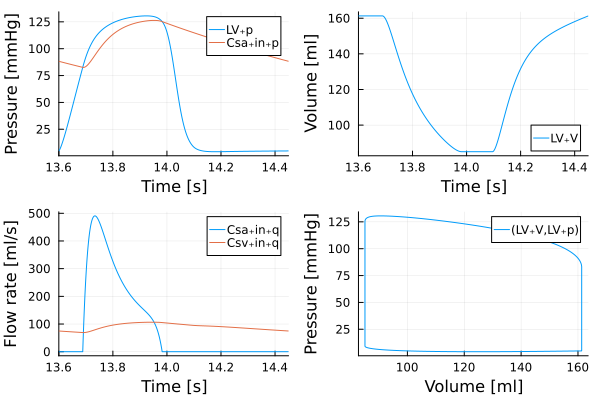

In [22]:
p1 = plot(sol, idxs=[LV.p,  Csa.in.p], tspan=(16 * τ, 17 * τ), xlabel = "Time [s]", ylabel = "Pressure [mmHg]",  hidexaxis = nothing) # Make a line plot
p2 = plot(sol, idxs=[LV.V], tspan=(16 * τ, 17 * τ),xlabel = "Time [s]", ylabel = "Volume [ml]",  linkaxes = :all)
p3 = plot(sol, idxs=[Csa.in.q,Csv.in.q], tspan=(16 * τ, 17 * τ),xlabel = "Time [s]", ylabel = "Flow rate [ml/s]", linkaxes = :all)
p4 = plot(sol, idxs=(LV.V, LV.p), tspan=(16 * τ, 17 * τ),xlabel = "Volume [ml]", ylabel = "Pressure [mmHg]", linkaxes = :all)

img = plot(p1, p2, p3, p4; layout=@layout([a b; c d]), legend = true)

img = DisplayAs.Text(DisplayAs.PNG(img))

img
#

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*